In [1]:
#Use miniconda-analysis environment
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import co2_timeseries_tools as co2tt
from scipy import stats
from scipy import signal
from ctsm_py import utils

/glade/u/home/dll/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Obs Data

In [2]:
path='/glade/work/dll/CTSM_py/notebooks/'
brw={'name':'Barrow', 'acronym': 'brw',  'lat': 71.3, 'lon':360-156.61, 'z': 11.0}
mlo={'name':'Mauna Loa', 'acronym': 'mlo', 'lat': 19.5, 'lon':360-155.6, 'z':3397.0}
alt={'name':'Alert', 'acronym': 'alt', 'lat': 82.5, 'lon':360-62.5, 'z':200.0}
azr={'name': 'Azores', 'acronym':'azr','lat':38.8, 'lon':360-27.4, 'z':19.0}
cba={'name': 'Cold Bay', 'acronym':'cba', 'lat':55.2, 'lon':360-162.7, 'z':21.3}
kum={'name':'Kumukahi', 'acronym':'kum', 'lat':19.7, 'lon':360-155.0, 'z':0.3}
ESRL=[brw, mlo, alt, azr, cba, kum]
lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7])
lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0])
#note that the 'lev' variable only goes from 0 to 1000, not sure how to translate from 'alt' to 'lev'
alt=np.array([11.0,3397.0,200.0,19.0,21.3,0.3])
cesm1levs=np.array([25,20,25,25,25,25])
cesm2levs=np.array([31,22,31,31,31,31])

In [3]:
minYear = 1981 # minimum year for an 'early' trend, used later for plotting

for site in ESRL:
#    print(site)
    filename=path+'co2_'+site['acronym']+'_surface-flask_1_ccgg_month.txt'
    #import glob
    #filename=glob.glob(partialname+ '*co2')
    with open(filename, 'r') as fid:
        first_line=fid.readline()
        nheader=first_line[-3:-1]
        nheader=np.int(np.float(nheader))
    data=np.loadtxt(filename, usecols=(1,2,3), skiprows=nheader)
    time=data[:,0]+data[:,1]/12
    co2=data[:,2]
    month=data[:,1]
    year=data[:,0]
    site['year']=year
    site['month']=month
    site['co2']=co2

### Problem 1
I would like to calculate max - min for each year but can't figure out how to loop over the years.
The code below calculates absolute min and max across all years

In [4]:
# I want this for every year
for i in range(len(ESRL)):
    nyr = ESRL[i]["co2"].max() - ESRL[i]["co2"].min()
    print(nyr)

98.58000000000004
90.74000000000001
77.64000000000004
80.95999999999998
88.39999999999998
84.44999999999999


### Model Data

In [5]:
simyrs             = "185001-201412"
var                = "CO2"

datadir            = "/glade/p/cesm/lmwg_dev/dll/"
subdir             = "/atm/proc/tseries/month_1/"
Mod1dir            = "CESM2_Coupled_NoCrop/"

sim                = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001"
sim2               = "b40.20th.1deg.coup.001"

In [6]:
data1          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim+".cam.h0."+var+"."+simyrs+".nc", decode_times=True), 'time')
data2          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim2+".cam2.h0."+var+".185001-200512.nc", decode_times=True), 'time')

### Converting CO2 units to ppm

In [7]:
#conversion of CESM CO2 to ppm
convert = 10.0**6 * 28.966/44.0

In [8]:
%%time
CESM1ppm = data2.CO2.sel(time=slice('1950','2014')) * convert
CESM2ppm = data1.CO2.sel(time=slice('1950','2014')) * convert

CESM1ppm.attrs['units'] = 'ppm'
CESM2ppm.attrs['units'] = 'ppm'

CPU times: user 32.2 s, sys: 1min 45s, total: 2min 18s
Wall time: 7min 30s


### Selecting sites for comparison to observations

In [10]:
#initialize list using '[]' and dictionary using '{}'
CESM1points = {}
CESM2points = {}

#lat and lon are actual values to pull out, level refers to a specific index, not a value, so requires 'isel'
for x in range(6):
    CESM1pointloop = CESM1ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM2pointloop = CESM2ppm.sel(lat=lats[x], lon=lons[x], method="nearest")
    CESM1pointloop = CESM1pointloop.isel(lev=cesm1levs[x])
    CESM2pointloop = CESM2pointloop.isel(lev=cesm2levs[x])
    CESM1points[x] = CESM1pointloop
    CESM2points[x] = CESM2pointloop

### Calculating detrended annual cycle for early and late time periods

In [11]:
CESM1_ann_early = {}
CESM1_ann_late  = {}
CESM2_ann_early = {}
CESM2_ann_late  = {}
CESM1_ann_early_detrend = {}
CESM1_ann_late_detrend  = {}
CESM2_ann_early_detrend = {}
CESM2_ann_late_detrend  = {}

for site, data in CESM1points.items():
    CESM1late   = data.sel(time=slice('2000','2005'))
    CESM1early  = data.sel(time=slice('1980','1985'))
    CESM1_ann_late[site] = CESM1late.groupby("time.month").mean()
    CESM1_ann_early[site] = CESM1early.groupby("time.month").mean()
    CESM1_ann_early_detrend[site] = signal.detrend(CESM1early.groupby("time.month").mean())
    CESM1_ann_late_detrend[site] = signal.detrend(CESM1late.groupby("time.month").mean())
print(CESM1_ann_early_detrend[1])
print(type(CESM1_ann_early_detrend))

for site, data in CESM2points.items():
    CESM2late   = data.sel(time=slice('2000','2005'))
    CESM2early  = data.sel(time=slice('1980','1985'))
    CESM2_ann_late[site] = CESM2late.groupby("time.month").mean()
    CESM2_ann_early[site] = CESM2early.groupby("time.month").mean()
    CESM2_ann_early_detrend[site] = signal.detrend(CESM2early.groupby("time.month").mean())
    CESM2_ann_late_detrend[site] = signal.detrend(CESM2late.groupby("time.month").mean())

[-1.0892944  -0.72491455 -0.1918335   0.95547485  1.4278259   1.0961609
  0.3114624  -0.26135254 -0.56903076 -0.76623535 -0.52960205  0.34158325]
<class 'dict'>


## Problem #2
### Detrended plot has oddly high late-season values
Bottom plot is detrended. Should I be using a different function? 

### Absolute value plot

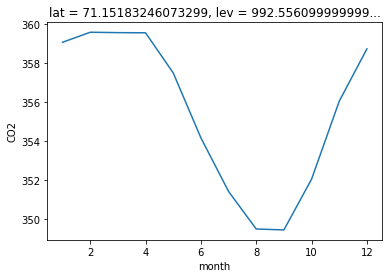

In [12]:
CESM1_ann_early[0].plot()

### Detrended Plot

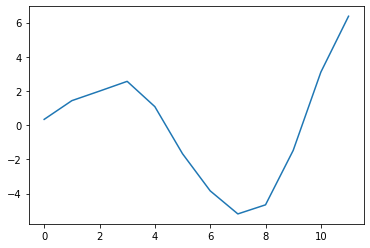

In [13]:
plt.plot(CESM1_ann_early_detrend[0])